# Machine Learning in Finance - Models Training

This notebook will focus on *how well we can forecast closing stocks using machine learning methods*.

*Authors:* [Mina Attia](https://people.epfl.ch/mina.attia), [Arnaud Felber](https://people.epfl.ch/arnaud.felber), [Rami Atassi](https://people.epfl.ch/rami.atassi) & [Paulo Ribeiro](https://people.epfl.ch/paulo.ribeirodecarvalho)

## Import

Import all python scripts and/or libraries needed.

In [1]:
import pandas as pd
from models.linear_regression import OLS, OLSLasso
from models.pearson_correlation import PearsonCorrelation
from models.random_forest import RandomForest

%load_ext autoreload
%autoreload 2


## Data

Tell where we use the data and describe it quickly. Better description will be given in the README.md file.

In [40]:
file_path = 'data/data_imputed.csv'
label = 'return'
N_JOBS = 4
VERBOSE = 1
data_full = pd.read_csv(filepath_or_buffer=file_path)


In [41]:
#standardize the data using sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer
data = data_full.copy().drop(columns=['permno', 'date', 'log_return', 'price', 'log_price'])
scaler = StandardScaler() #StandardScaler looks best (tried them all  quickly)
data[data.columns] = scaler.fit_transform(data)
X = data.drop(columns=['return'])
y = data[label]

In [42]:
import sklearn.linear_model as sk
# #elastic net
# 
# model = sk.ElasticNet(alpha=0.1, l1_ratio=0.1)
# model.fit(X, y)
# model.score(X, y)
model = sk.LassoCV(cv=3, n_jobs=N_JOBS, verbose=VERBOSE, n_alphas=10)
model.fit(X, y)
model.score(X, y)



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
..............................[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:   29.5s finished


0.0035194295900355943

## Methods

Describe which method we will train and test.

### Person Correlation Matrix

This allows to see which predictors are highly correlated. If two predictors are highly correlated we might don't want to keep both then we delete the least correlated with our label (return).

In [47]:
correlation = PearsonCorrelation(data=data) # Takes a minute

In [48]:
highest_pairs_correlation = correlation.get_sorted_correlation_pairs(ascending=False, top_k_pairs=10)
display(highest_pairs_correlation)

,pair,correlation
0,"(EBM, BPEBM)",0.999808
1,"(AM, Leverage)",0.986174
2,"(RealizedVol, IdioVol3F)",0.982106
3,"(zerotrade, zerotradeAlt12)",0.973945
4,"(HerfAsset, Herf)",0.945221
5,"(dNoa, NOA)",0.944448
6,"(zerotradeAlt1, zerotrade)",0.942450
7,"(InvestPPEInv, dNoa)",0.923709
8,"(DolVol, Size)",0.922138
9,"(AssetGrowth, dNoa)",0.918073


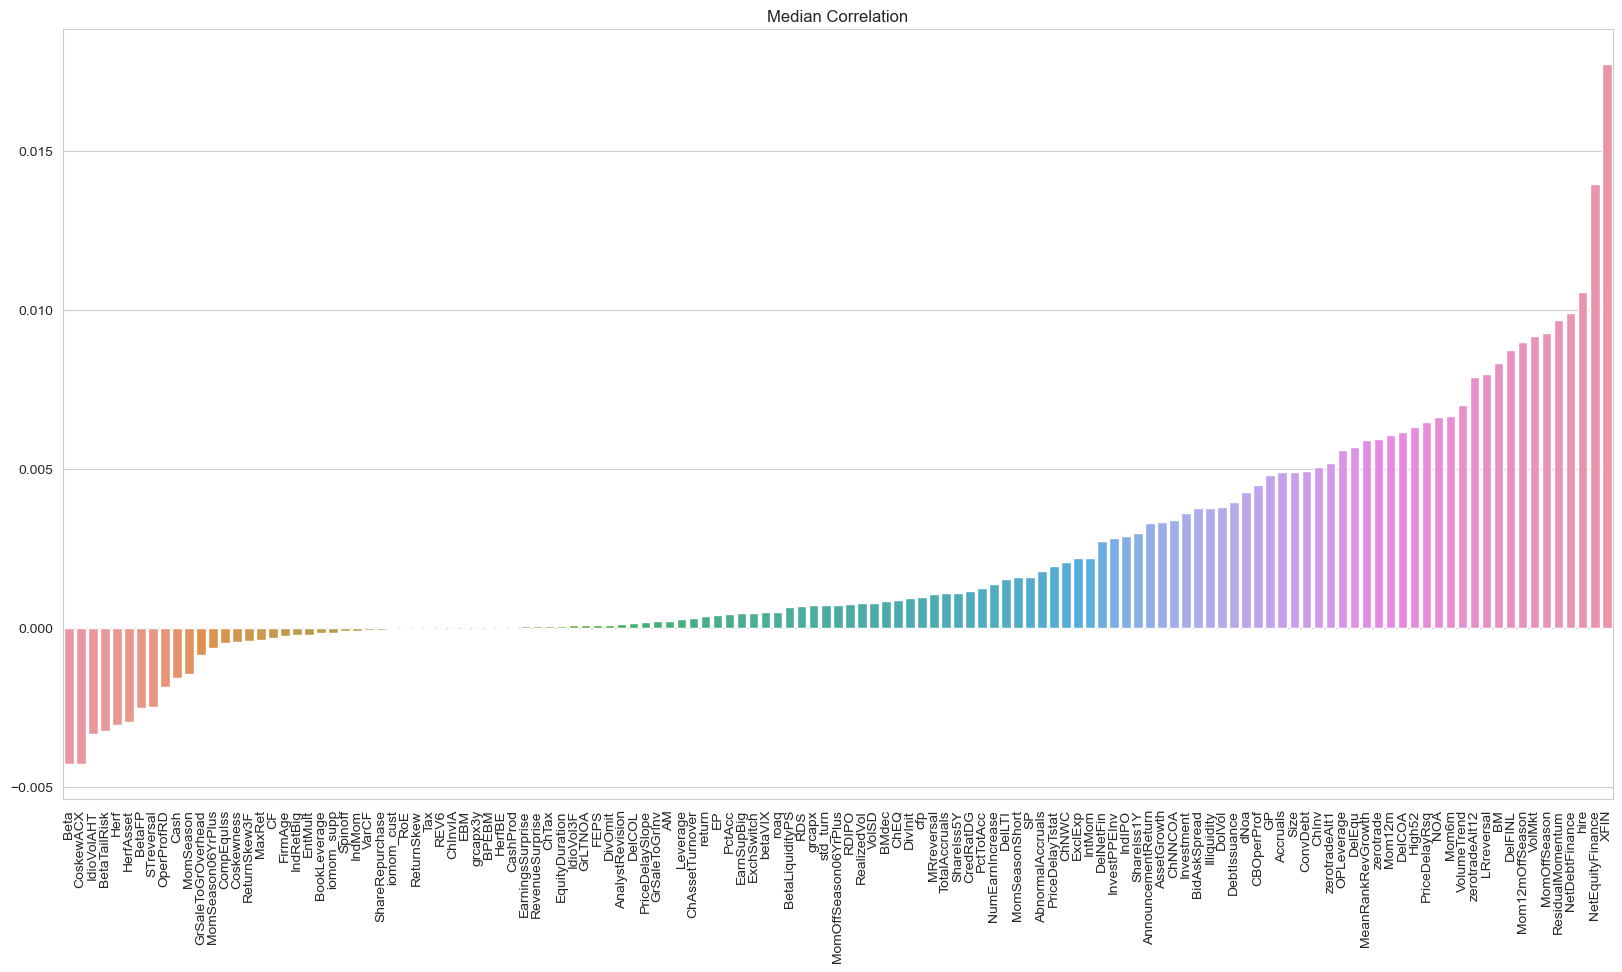

In [49]:
correlation.plot(plot_type= 'median') # plot_type can be 'mean' or 'median' (or 'heatmap' but it is not recommended for large datasets)

It is interesting that Beta is inversely correlated with the other predictors, which accentuates the importance of the other predictors compared to a traditional market prediction.

### OLS

One basic idea is to compute the linear regression of our predictors in function of our label and to see the weights given to each predictor. As seen in class, using regularization can help achieve predictors selection. We then implement :

1) Simple OLS
2) Lasso OLS


#### Simple OLS

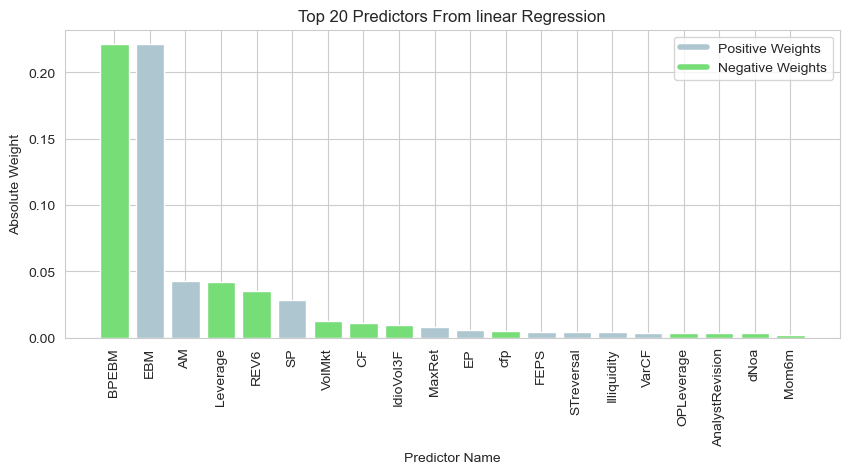

R-Square of the Simple OLS: 0.008


In [7]:
ols_model = OLS(predictors=X,
                label=y)
ols_model.fit()
ols_model.show_weights()

print(f'R-Square of the Simple OLS: {ols_model.r_square:.3f}')

#### Lasso OLS

In [ ]:
ols_lasso_model = OLSLasso(predictors=X,
                           label=y)

ols_lasso_model.alpha_cross_validation(n_jobs=1, from_=0.05, to_=0.5, val_number=10)
ols_lasso_model.fit()
ols_lasso_model.show_weights()

print(f'R-Square of the Lasso OLS: {ols_lasso_model.r_square:.3f}')

### Random Forest

Using Random Forest can also be a good way to select predictors. We then train a Random Forest into our label using the whole Dataset and we look at the importance of each predictors.

In [44]:
# test_data = data.sample(300000)
rf = RandomForest(data=data, target='return')

In [ ]:
rf.hyperparameter_tuning_with_crossvalidation(nmax_features=['sqrt', 'log2'], n_estimators=[50, 150], max_depth=[3],cv_splits=3, n_jobs=N_JOBS, verbose=VERBOSE)

27 min... Zzzz

In [46]:
rf.set_model(n_jobs=N_JOBS, verbose = VERBOSE, n_estimators=100, max_depth=3, max_features='log2')
rf.fit_predict_and_print_score()

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   43.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


With the following data:
- Data shape: (1745273, 129)
- Target: return
and the following hyperparameters:
- n_estimators: 100
- max_depth: 3
- max_features: log2
The R2 score is: -0.017611908143600585
The MSE is: 0.22076142212382305


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


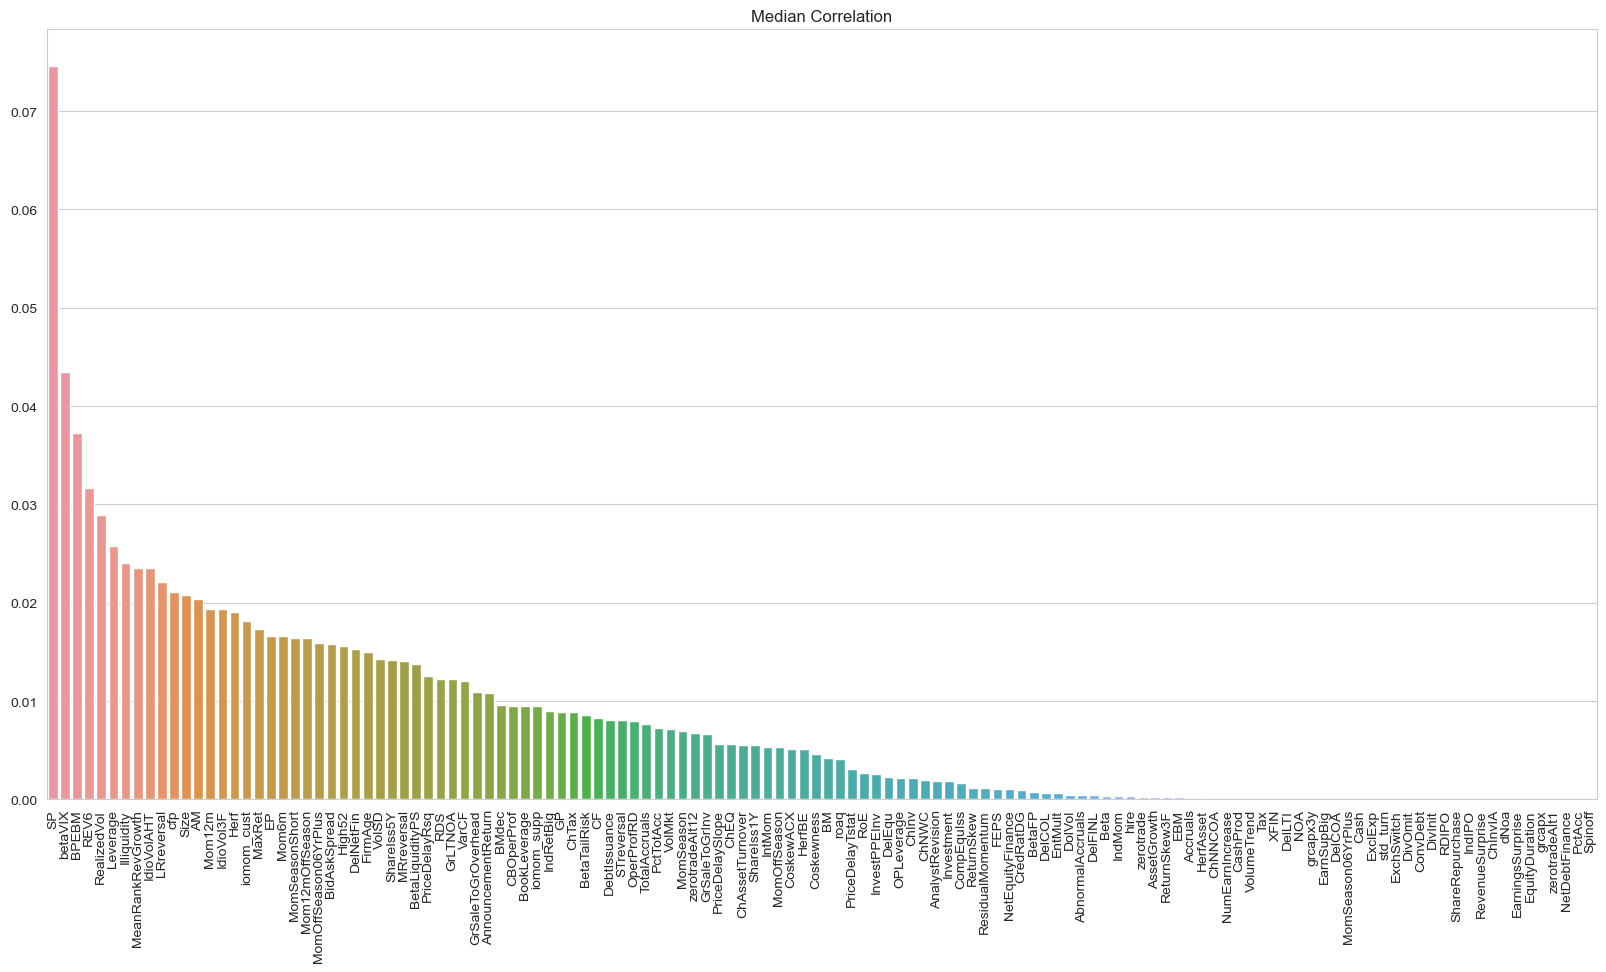

In [50]:
rf.plot_feature_importance()

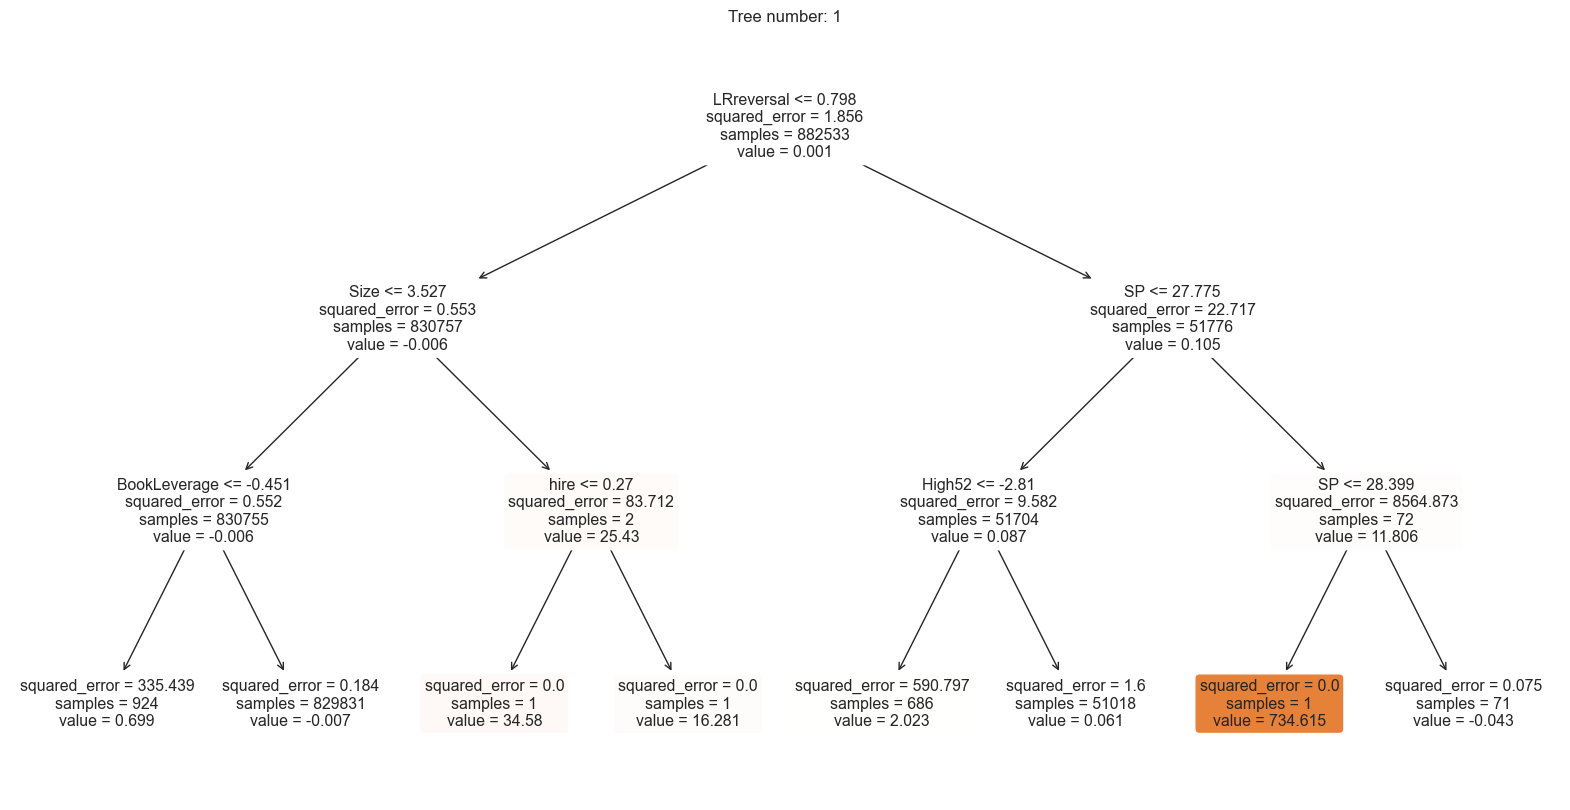

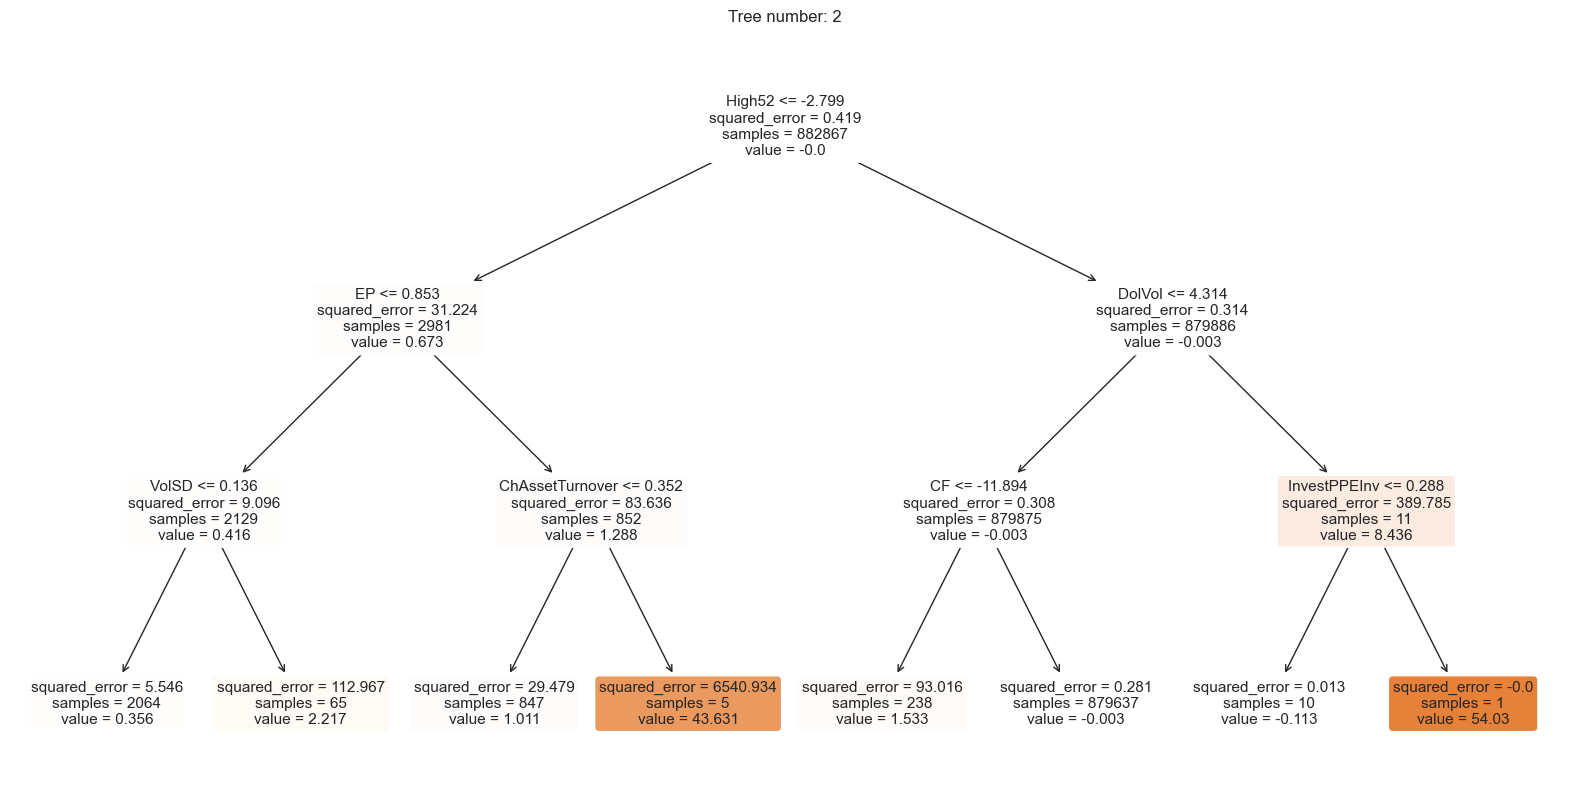

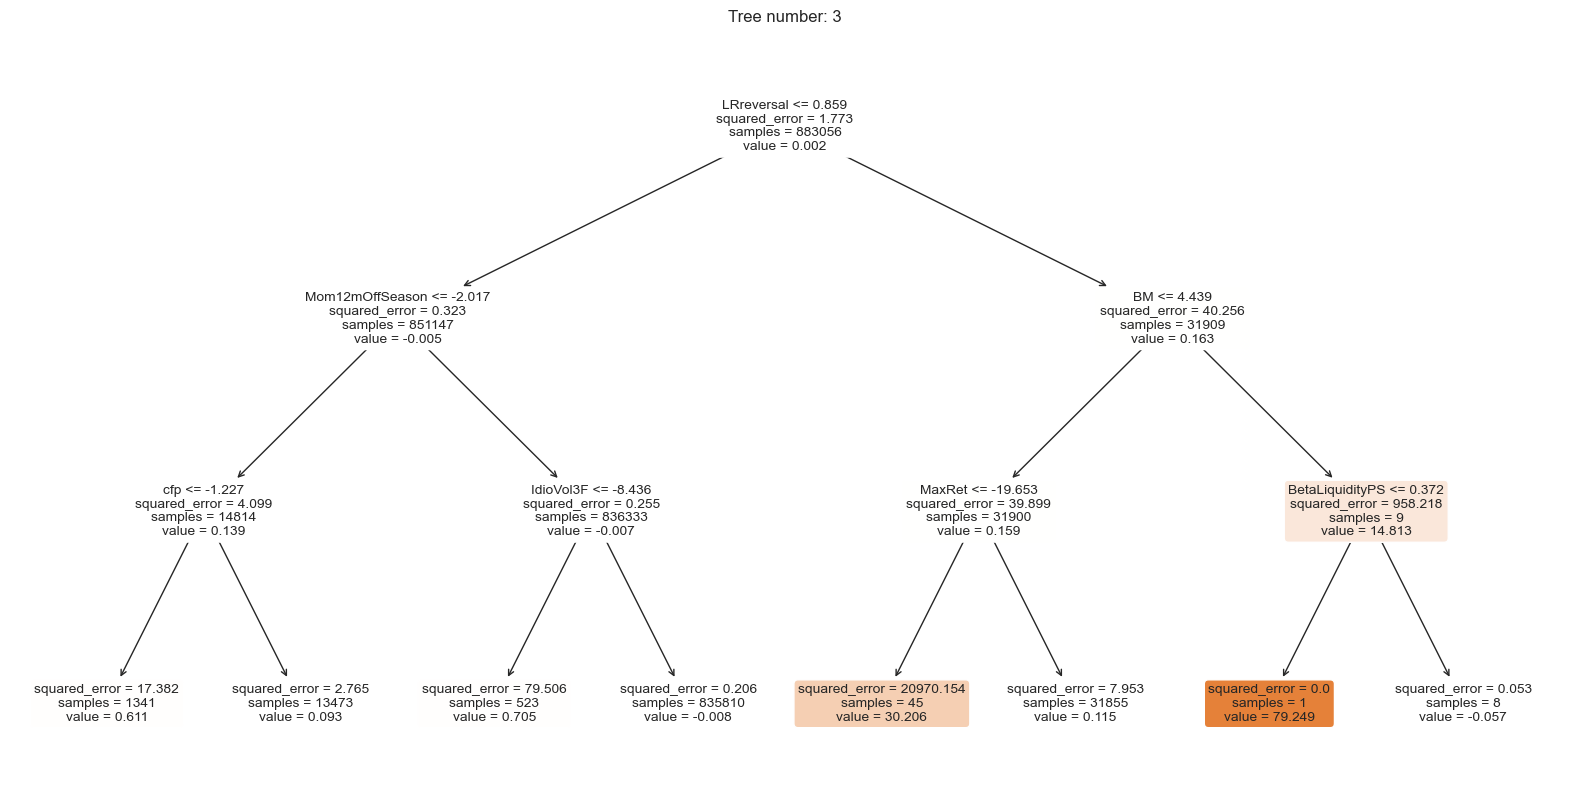

In [51]:
rf.plot_decision_tree()

## Results

We will test our models and compare them to see which one outperform the others.